# Genetic Algorithms

Some problems solved using genetic agorithms programmed from scratch 

# Preamble

We import some libraies and set some jupyter settings

In [177]:
import numpy as np
from functools import cache
# To explicitely choose matplotlib jupyter inline backend
%matplotlib inline
import matplotlib.pyplot as plt

# Base Algorithm

We define a class that executes the agorithm given its components:
- An initial populaion generator
- Some aptitude evaluator for each chromosome
- A selector that chooses chromosomes that will pass to the next generation
- A crosser that will cross the selected chromosomes
- A mutator tha will randomly mutate some genes based on some probability

Additionaly we add an example logger tha does nothing but can be extended for debbugging and statistics gathering purposes

In [178]:
class Logger:
   def __init__(self, chromosome_size, population_size, num_generations, mut_prob):
      ...

   def log_gen(self, population):
      ...

   def log_aptitude(self, aptitude, population, gen):
      ...

   def log_sel(self, population, aptitude, gen):
      ...

   def log_cross(self, population, gen):
      ...

   def log_mut(self, population, gen):
      ...


class GeneticAlgorithm:
   def __init__(self, pop_gen, apt_ev, sel, cross, mut, get_logger):
      self.pop_gen = pop_gen
      self.apt_ev = apt_ev
      self.sel = sel
      self.cross = cross
      self.mut = mut
      self.get_logger = get_logger 

   def run(self, chromosome_size, population_size, num_generations, mut_prob):
      logger = self.get_logger(chromosome_size, population_size, num_generations,mut_prob)

      population = self.pop_gen(chromosome_size, population_size)
      logger.log_gen(population)

      aptitude = self.apt_ev(population)
      logger.log_aptitude(aptitude, population, 0)
      for i in range(1, num_generations):
          population = self.sel(population, aptitude)
          logger.log_sel(population, aptitude, i)
          population = self.cross(population)
          logger.log_cross(population, i)
          population = self.mut(population, mut_prob)
          logger.log_mut(population, i)
          aptitude = self.apt_ev(population)
          logger.log_aptitude(aptitude, population, i)
      return population, logger

# Particular implementaions

Next we will define the building parts of a simple (binary genes) genetic algorithm

## Randomness 
We will creae a radom number generator for use in the algorithm, feel free to seed it to get reproducible results

In [179]:
rng = np.random.default_rng(seed=None)

## Generation

We Generate a matrix where each row corresponds to a chromosome and has as many rows as the population has members

In [180]:
def bingen(chromosome_size: int, population_size: int): 
   """
   Generates a binary population
   """ 
   return rng.integers( low=0, high=2, size=(population_size, chromosome_size), dtype=np.uint8)

## Crossbreeding

We choose pivot points for each chromosome, up to its corresponding point, the chromosome will retain its genes and the rest will be changed with the corresponding genes from the next gene (last takes from first) 

In [181]:
def cross_halves(population):
   """
   This crosses a population of chromosomes, with a random pivot for each gene,
   keeping up to the pivot from the original gene and the rest are from the following gene, 
   last gene takes first as next
   """
   K, l = population.shape
   first_parent_keep = rng.integers(1, l, size=(K, l), dtype=np.int64)
   mask = np.arange(K * l).reshape((K, l)) % l < first_parent_keep
   children = np.where(mask, population, np.roll(population, shift=-1, axis=0))
   return children

## Mutation
As our genes are booleans we choose radomly from the matrix population genes to toggle

In [182]:
def binmut(population, mut_prob: float):
   """
   Randomly toggles bits in a binary population
   """
   rnd_mask = rng.uniform(size=population.shape) <= mut_prob
   return np.logical_not(population,where=rnd_mask).astype(np.uint8)

## Selection

We will use a roulette wheel selection algorithm, it increases relative probaility of choosing best genes by some factor and then chooses an equal size population based on those probabilities

In [183]:
def roulette_wheel_sel(population, aptitude, factor = 10):
   prob = factor * aptitude
   prob = prob / prob.sum()

   return rng.choice(population, size=population.shape[0], p=prob, axis=0)

## Aptitude
Aptitude check is specific to each problem, the only requirement to worki with our selection algorithm is to give greater aptitude to better chromosomes

## Logging

We create logger that saves on aptitude check the following values for each generation:
- Maximum aptitude
- Best value 
- Mean aptitude
- Mean value
Also it has an utility method to graph the results

In [299]:
class StatLogger(Logger):
   def __init__(self, chromosome_size, population_size, num_generations, mut_prob, decode):
      self.stats = np.zeros(shape = (num_generations,5))
      self.stats[:,0] = np.arange(num_generations)
      self.decode = decode
      self.chromosome_size = chromosome_size
      self.population_size = population_size
      self.num_generations = num_generations
      self.mut_prob = mut_prob

   def log_aptitude(self, aptitude, population,gen):
      max_ap = aptitude.max()
      arg_max = np.argmax(aptitude)
      self.stats[gen,1] = max_ap
      self.stats[gen,3] = aptitude.mean()
      if self.decode is not None:
         vals = self.decode(population)
         max_val = vals[arg_max]
         mean_val = vals.mean()
         self.stats[gen,2] = max_val
         self.stats[gen,4] = mean_val

   def show(s):
      fig, ax_or = plt.subplots(2,2 if s.decode is not None else 1, layout="constrained")
      ax = ax_or.flatten()
      fig.set_dpi(100)


      ax[0].grid()
      ax[0].scatter(s.stats[:, 0], s.stats[:, 1], c='lightcoral', edgecolors='darkred')
      ax[0].set(title="Max Aptitude",ylabel="Aptitude", xlabel="Generation")

      ax[1].grid()
      ax[1].scatter(s.stats[:, 0], s.stats[:, 3], c='lightcoral', edgecolors='darkred')
      ax[1].set(title="Mean Aptitude",ylabel="Aptitude", xlabel="Generation")

      if s.decode is not None:
         ax[2].grid()
         ax[2].scatter(s.stats[:, 0], s.stats[:, 2], c='cyan',edgecolors='darkcyan')
         ax[2].set(title="Best value",ylabel="Value", xlabel="Generation")

         ax[3].grid()
         ax[3].scatter(s.stats[:, 0], s.stats[:, 4], c='cyan',edgecolors='darkcyan')
         ax[3].set(title="Mean Value",ylabel="Value", xlabel="Generation")


      params = f"""
      Parameters:
      - Chromosome size: {s.chromosome_size}
      - Population size: {s.population_size}
      - Number of generations:  {s.num_generations}
      - Mutation probability:  {s.mut_prob}
      """
      results = f"""
      Last Best:
      - Aptitude: {s.stats[-1,1]}
      """

      if s.decode is not None: 
         fig.text(0.1,1.0,params,fontsize=10,weight="bold")
         results += f"- Value:{s.stats[-1,2]}\n"
         fig.text(0.6,1.0,results,fontsize=10,weight="bold")
      else:
         fig.text(0.1,1.2,params,fontsize=10,weight="bold")
         fig.text(0.1,1.1,results,fontsize=10,weight="bold" )
      return fig
      

# Problem 1. Finding roots

We are going to use a genetic algorithm to find the roots of the polynomial $5x^5 -3x^4 -x^3 -5x^2-x-3$ over the interval $[1,1.5]$

In [185]:
def eq(x):
   return 5*x**5 - 3 * x**4 - x**3 - 5*x**2 - x -3

## Aptitude evaluation

We will treat our binary chromosome as a big endian binary number from $0$ up to $2^l - 1$ (where $l$ is the length of the chromosome) and map that number to the wanted range ($[1,1.5]$ in our case) and then evauate it over the polynomial, as we want to find roots, the closer to 0 the better (doesn' matter if we are getting close from below or above) so we arbitrarily set 10 as our max aptitude, the aptitude is thus given by subtracting the absolute value of the result from 10  

In [186]:
@cache # We cache so it will only be evaluated the first time for a single length of chromosome
def pow_of_two(n: int, inverse=True):
   powers = 2 ** np.arange(n,dtype=np.uint64)
   if inverse:
     return powers[::-1]
   
   return powers

def bin_to_dec_p1(population):
   _,l = population.shape
   return (population * pow_of_two(l)).sum(axis=1,dtype=np.uint64) 

def decode_p1(population, sol_range):
   dec = bin_to_dec_p1(population)
   _,l = population.shape
   a,b = sol_range
   return dec.astype(np.float64) * (b-a)/(2**l - 1) + a 

def aptitude_p1(population):
   vals = decode_p1(population, (1,1.5))
   return 10 - abs(eq(vals))

## Solution

In [222]:
p1 = GeneticAlgorithm(
    bingen,
    aptitude_p1,
    roulette_wheel_sel,
    cross_halves,
    binmut,
    # We do this so we can pass the logger generator with the needed decoder
    lambda a,b,c,d: StatLogger(a,b,c,d,lambda x: decode_p1(x,(1,1.5))), 
)

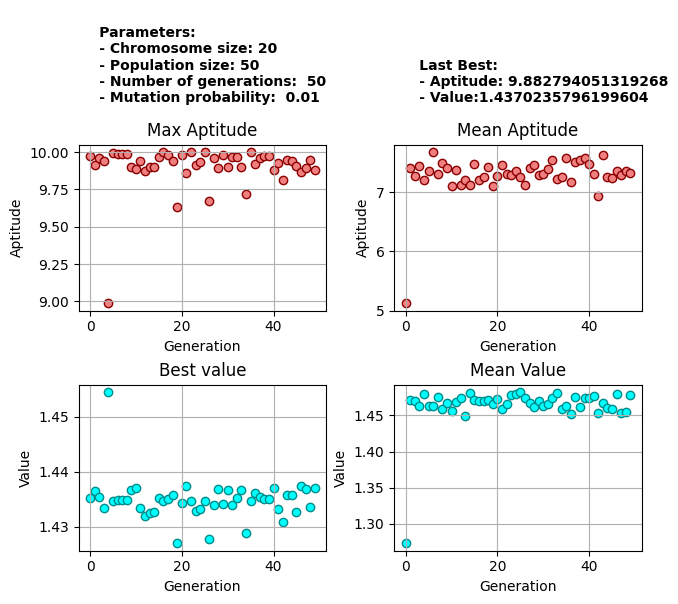

In [303]:
# Change parameters here to rerun the algorithm
( p, s,) = p1.run(
    chromosome_size=20,
    population_size=50,
    num_generations=50,
    mut_prob=0.01,
)
_ = s.show()

# Problem 2: Creating a Diet

In this problem we will take a list of foods with their calories, protein, fats and carbohidrates and use it to generate a viable diet.

## Data Loading

In [189]:
# Maybe overkill but useful to read csv
import pandas as pd

In [282]:
data = pd.read_csv(
    "alimentos.csv",
    sep=",",
    header=None,
    index_col=0,
    names=(
        "calories",
        "protein",
        "fat",
        "carbohydrate",
    ),
)
# For use in aptitude evaluation
numeric_data = data[
    [
        "calories",
        "protein",
        "fat",
        "carbohydrate",
    ]
].to_numpy()
data

,calories,protein,fat,carbohydrate
Leche chocolatada,62.0,10.0,3.0,1.1
Leche descremada en polvo,36.0,5.1,3.5,0.1
Leche entera,57.0,4.5,3.0,3.0
Leche entera azucarada,79.0,10.0,3.0,3.0
Leche descremada,45.0,4.7,3.1,1.5
...,...,...,...,...
Pochoclo,386.0,76.4,12.9,5.0
Pochoclo acaramelado,520.0,64.0,4.0,28.0
Semillas de amapola,533.0,23.7,18.0,44.7
Semillas de girasol,560.0,19.9,23.0,47.3


## Aptitute

We set a reference diet, also for simplicity in indexing we will take the biggest power of 2 we can still index in the list, so we will consider the first 256 items with equal probability, the aptitude formula uses the relative error of each value with respect to the reference diet and adds them, we subtract the total error from some arbitrary value that does not yield negative aptitudes 

In [257]:
goal_diet = np.array([2500,100,60,275])
# For simplicity we will just consider the first 256 items in the list
FOOD_INDEX_SIZE = 8 

def decode_p2(population):
   num_foods_day = population.shape[1]//FOOD_INDEX_SIZE
   population_size = population.shape[0]
   powers = pow_of_two(FOOD_INDEX_SIZE)
   food_pop = population.reshape((population_size, num_foods_day, FOOD_INDEX_SIZE))
   food_pop = (food_pop*powers).sum(axis=-1) 
   return food_pop


def aptitude_p2(population):
   food_pop = decode_p2(population)
   # This gets the corresponding food given indexes and sums the diet values for each component
   food_values = numeric_data[food_pop].sum(axis=1)
   # We calculated the relative error of each vaule and added them, then we subtract from 10
   aptitude = 40-((abs(food_values - goal_diet) / goal_diet)).sum(axis=-1)
   if (np.any(aptitude < 0)):
      print("NEGATIVE aptitude")
      print(food_values)
      print(abs( food_values - goal_diet))
      print(aptitude)
   return aptitude

## Solution

In [300]:
p2 = GeneticAlgorithm(
    lambda c,p: bingen(c*FOOD_INDEX_SIZE,p),
    aptitude_p2,
    roulette_wheel_sel,
    cross_halves,
    binmut,
    # We do this so we can pass the logger generator with the needed decoder
    lambda a,b,c,d: StatLogger(a,b,c,d,None), 
)

,calories,protein,fat,carbohydrate
Avellana,647.0,19.80,10.80,63.20
Bombas,373.0,33.40,14.00,20.40
Almendra,547.0,19.60,18.60,54.10
"Queso ""Philadelphia"" ligth",200.0,6.60,10.00,16.60
Hongos,28.0,4.40,2.70,0.30
Ananá,35.0,8.34,0.38,0.12
Queso roquefort,364.0,0.00,20.00,31.00
Vacío,144.0,0.00,21.60,5.70
Leche chocolatada,62.0,10.00,3.00,1.10
Total,2400.0,102.14,101.08,192.52


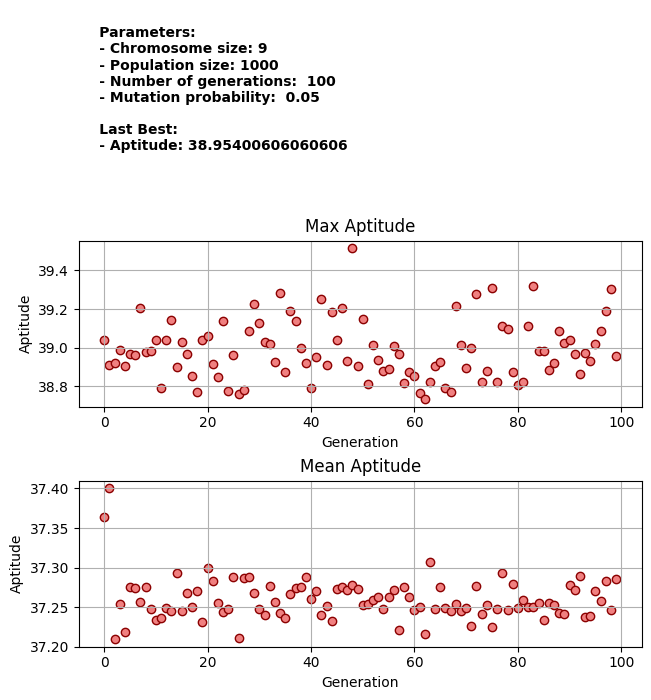

In [301]:
r,s = p2.run(
   # due to how we defined the genetic algorithm this actually refers to the number of foods in the diet
   chromosome_size=9, 

   population_size=1000,
   num_generations=100,
   mut_prob=0.05
   )
fig=s.show()
ap = aptitude_p2(r)
best_idx = np.argmax(ap)
best_food_idx = decode_p2(r[best_idx][np.newaxis,:])[0]
best_food = data.iloc[best_food_idx].copy()
sums = best_food.sum(numeric_only=True)
best_food.loc['Total'] = sums
best_food.loc['Goal'] = goal_diet
best_food.loc['Difference'] = goal_diet - sums
best_food